In [195]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install tabulate
%pip install statsmodels --index-url=https://pypi.org/simple
%pip install sklearn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pi

**LIBRERIE NECESSARIE**

In [196]:
from tabulate import tabulate
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

**INFORMAZIONI SUL DATASET**

In [197]:
# Scaricare il dataset da Kaggle (simulato in locale per questo esempio)
path = kagglehub.dataset_download("khushipitroda/stock-market-historical-data-of-top-10-companies")
file_path = os.path.join(path, "data.csv")

# Leggere il file CSV
df = pd.read_csv(file_path)

# Stampare numero di righe nel dataset
print(f"Numero di righe nel dataset: {df.shape[0]}\n")

# Stampare le prime righe in una tabella formattata
print("Prime righe del dataset:\n")
df.head()

Numero di righe nel dataset: 25160

Prime righe del dataset:



,Company,Date,Close/Last,Volume,Open,High,Low
0,AAPL,07/17/2023,$193.99,50520160,$191.90,$194.32,$191.81
1,AAPL,07/14/2023,$190.69,41616240,$190.23,$191.1799,$189.63
2,AAPL,07/13/2023,$190.54,41342340,$190.50,$191.19,$189.78
3,AAPL,07-12-2023,$189.77,60750250,$189.68,$191.70,$188.47
4,AAPL,07-11-2023,$188.08,46638120,$189.16,$189.30,$186.60


**FASE DI ETL**

In [198]:
# Rimuovere duplicati
df_cleaned = df.drop_duplicates()

# Rimuovere valori nulli
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")
# Rinominare le colonne
df_cleaned = df_cleaned.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close/Last': 'close/last',
    'Volume': 'volume',
    'Company': 'company'
})

# Funzione per convertire i formati delle date
def correct_date_format(date):
    try:
        # Tenta di interpretare la data come MM/DD/YYYY (o MM-DD-YYYY)
        if '-' in date or '/' in date:
            return pd.to_datetime(date, dayfirst=False, errors='coerce').strftime('%d/%m/%Y')
        else:
            return date  # Restituisci la data originale se non è in un formato valido
    except Exception as e:
        print(f"Errore durante la conversione della data: {date}")
        return None  # Restituisci None per valori non validi

# Applicare la funzione alla colonna 'date'
df_cleaned['date'] = df_cleaned['date'].astype(str).apply(correct_date_format)

# Convertire la colonna 'date' in datetime senza specificare il formato
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Pulizia e conversione della colonna 'close/last'
df_cleaned['close/last'] = df_cleaned['close/last'].replace('[\$,]', '', regex=True).astype(float)

# Aggiungere colonne derivate
df_cleaned['daily_return'] = df_cleaned['close/last'].pct_change() * 100
df_cleaned['rolling_average_7d'] = df_cleaned['close/last'].rolling(window=7).mean()
df_cleaned['rolling_average_30d'] = df_cleaned['close/last'].rolling(window=30).mean()

output_file = 'cleaned_stock_market.csv'
df_cleaned.to_csv(output_file, index=False)
print(f"\nDataset pulito e salvato in: {output_file}")

print("Ultimi dati:\n")
df_cleaned.tail()

Numero di righe nel dataset senza valori nulli: 25160

Dataset pulito e salvato in: cleaned_stock_market.csv
Ultimi dati:



,company,date,close/last,volume,open,high,low,daily_return,rolling_average_7d,rolling_average_30d
25155,NFLX,2013-07-24,34.4714,33395351,$35.6743,$36.0357,$34.3143,-2.204910,35.034157,37.436623
25156,NFLX,2013-07-23,35.7514,76792963,$35.9143,$37.4621,$35.1714,3.713223,35.057414,37.235813
25157,NFLX,2013-07-22,37.4228,44791095,$38.1214,$38.3928,$36.7314,4.675062,35.414057,37.107050
25158,NFLX,2013-07-19,37.7966,18098750,$38.2043,$38.2784,$37.5971,0.998856,35.838886,37.014983
25159,NFLX,2013-07-18,38.0586,20418642,$38.6157,$38.6157,$37.7143,0.693184,36.276643,36.912890


In [199]:
# Informazioni generali sul dataset
print("Informazioni generali sul dataset:")
df_info = pd.DataFrame({
    "Column": df_cleaned.columns,
    "Non-Null Count": df_cleaned.notnull().sum().values,
    "Dtype": df_cleaned.dtypes.values
})
print(tabulate(df_info, headers="keys", tablefmt="grid"))

# Statistiche descrittive
print("\nStatistiche descrittive:")
df_stats = df_cleaned.describe().T  # Transpose for better readability
df_stats.head()


Informazioni generali sul dataset:
+----+---------------------+------------------+----------------+
|    | Column              |   Non-Null Count | Dtype          |
+====+=====================+==================+================+
|  0 | company             |            25160 | object         |
+----+---------------------+------------------+----------------+
|  1 | date                |            25160 | datetime64[ns] |
+----+---------------------+------------------+----------------+
|  2 | close/last          |            25160 | float64        |
+----+---------------------+------------------+----------------+
|  3 | volume              |            25160 | int64          |
+----+---------------------+------------------+----------------+
|  4 | open                |            25160 | object         |
+----+---------------------+------------------+----------------+
|  5 | high                |            25160 | object         |
+----+---------------------+------------------+--------

,count,mean,min,25%,50%,75%,max,std
date,25160,2018-07-15 16:11:49.697933056,2013-07-18 00:00:00,2016-01-14 18:00:00,2018-07-16 12:00:00,2021-01-13 06:00:00,2023-07-17 00:00:00,NaN
close/last,25160.0,102.455878,1.62,36.5675,65.68,134.235025,691.69,101.991372
volume,25160.0,51317642.694754,1143952.0,12003942.5,26720830.0,68572694.0,1065209454.0,63991428.709405
daily_return,25159.0,0.562116,-34.33584,-1.145935,-0.074599,0.92828,9599.353448,62.767819
rolling_average_7d,25154.0,102.453101,1.701429,36.6825,65.784443,134.776786,680.15,101.816504


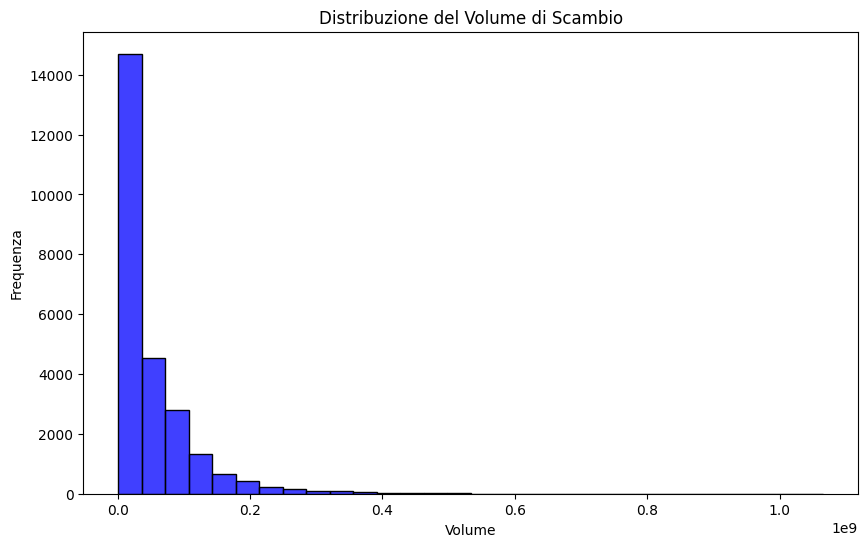

In [200]:
# Istogramma del volume di scambio
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['volume'], kde=False, bins=30, color='blue')
plt.title('Distribuzione del Volume di Scambio')
plt.xlabel('Volume')
plt.ylabel('Frequenza')
# plt.savefig('volume_histogram.png')
plt.show()

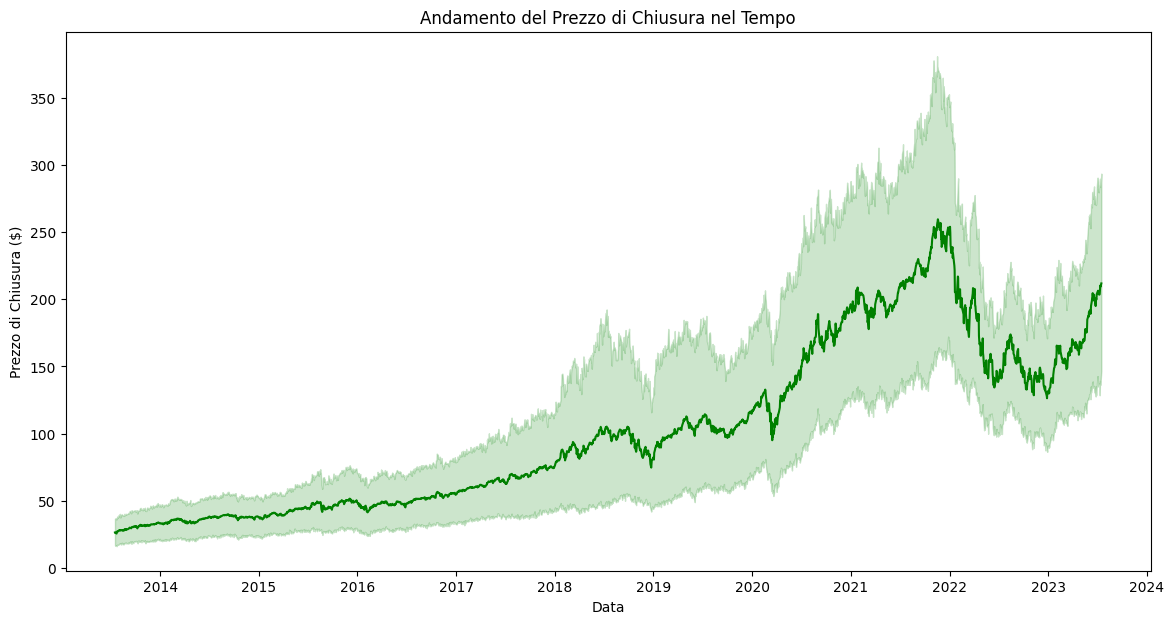

In [201]:
# Grafico a linee per l'andamento del prezzo di chiusura
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='close/last', data=df_cleaned, color='green')
plt.title('Andamento del Prezzo di Chiusura nel Tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura ($)')
# plt.savefig('line_plot_close.png')
plt.show()

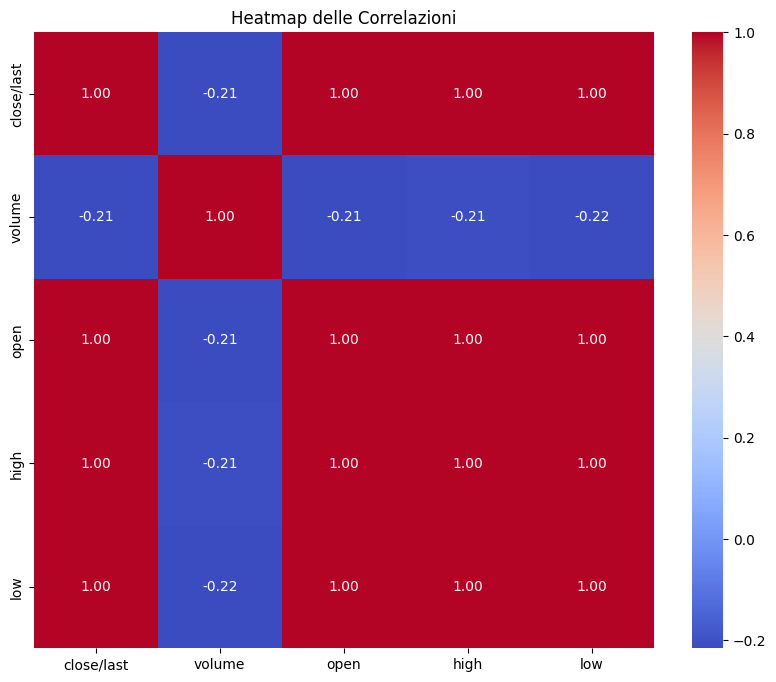

In [202]:
# Conversione delle colonne 'open', 'high', e 'low' in float
columns_to_convert = ['open', 'high', 'low']

for col in columns_to_convert:
    df_cleaned[col] = df_cleaned[col].replace('[\$,]', '', regex=True).astype(float)

# Heatmap delle correlazioni
plt.figure(figsize=(10, 8))
corr = df_cleaned[['close/last', 'volume', 'open', 'high', 'low']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap delle Correlazioni')
# plt.savefig('heatmap_corr.png')
plt.show()

**INIZIO SERIE TEMPORALI**

In [203]:
# Caricamento dei dati
df = pd.read_csv("cleaned_stock_market.csv")

# Selezionare i dati di interesse, incluso 'volume'
df_apple = df[df['company'] == 'AAPL'][['date', 'close/last', 'volume']]

# Sostituisci separatori misti
df_apple['date'] = df_apple['date'].str.replace('-', '/')

# Convertire la colonna 'date' in formato datetime
df_apple['date'] = pd.to_datetime(df_apple['date'], errors='coerce')

# Verifica righe con valori NaT
print(f"Valori NaT nella colonna 'date': {df_apple['date'].isnull().sum()}")
if df_apple['date'].isnull().any():
    print("Righe con date non valide:")
    print(df_apple[df_apple['date'].isnull()])

# Rimuovere righe con date mancanti o valori mancanti in 'close/last' o 'volume'
df_apple = df_apple.dropna(subset=['date', 'close/last', 'volume'])

# Conferma i valori minimi e massimi di 'date'
print(f"Data minima: {df_apple['date'].min()}")
print(f"Data massima: {df_apple['date'].max()}")

# Crea una sequenza completa di date tra il minimo e il massimo
full_date_range = pd.date_range(start=df_apple['date'].min(), end=df_apple['date'].max(), freq='D')

# Reindicizza il DataFrame con questa sequenza
df_apple = df_apple.set_index('date').reindex(full_date_range)

# Rinomina l'indice in 'date'
df_apple.index.name = 'date'

# Interpola i valori mancanti
df_apple['close/last'] = df_apple['close/last'].interpolate(method='linear')
df_apple['volume'] = df_apple['volume'].interpolate(method='linear')

# Verifica la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Controllo finale
print(f"Numero di osservazioni nella serie temporale: {len(df_apple)}")
print("Prime righe della serie temporale:")
print(df_apple.head())
print("Ultime righe della serie temporale:")
print(df_apple.tail())


Valori NaT nella colonna 'date': 0
Data minima: 2013-07-18 00:00:00
Data massima: 2023-07-17 00:00:00
Frequenza rilevata: D
Numero di osservazioni nella serie temporale: 3652
Prime righe della serie temporale:
            close/last        volume
date                                
2013-07-18     15.4199  2.186325e+08
2013-07-19     15.1768  2.685489e+08
2013-07-20     15.1930  2.482489e+08
2013-07-21     15.2092  2.279490e+08
2013-07-22     15.2254  2.076490e+08
Ultime righe della serie temporale:
            close/last        volume
date                                
2023-07-13      190.54  4.134234e+07
2023-07-14      190.69  4.161624e+07
2023-07-15      191.79  4.458421e+07
2023-07-16      192.89  4.755219e+07
2023-07-17      193.99  5.052016e+07


**DECOMPOSIZIONE SERIE TEMPORALE**

Frequenza rilevata: D


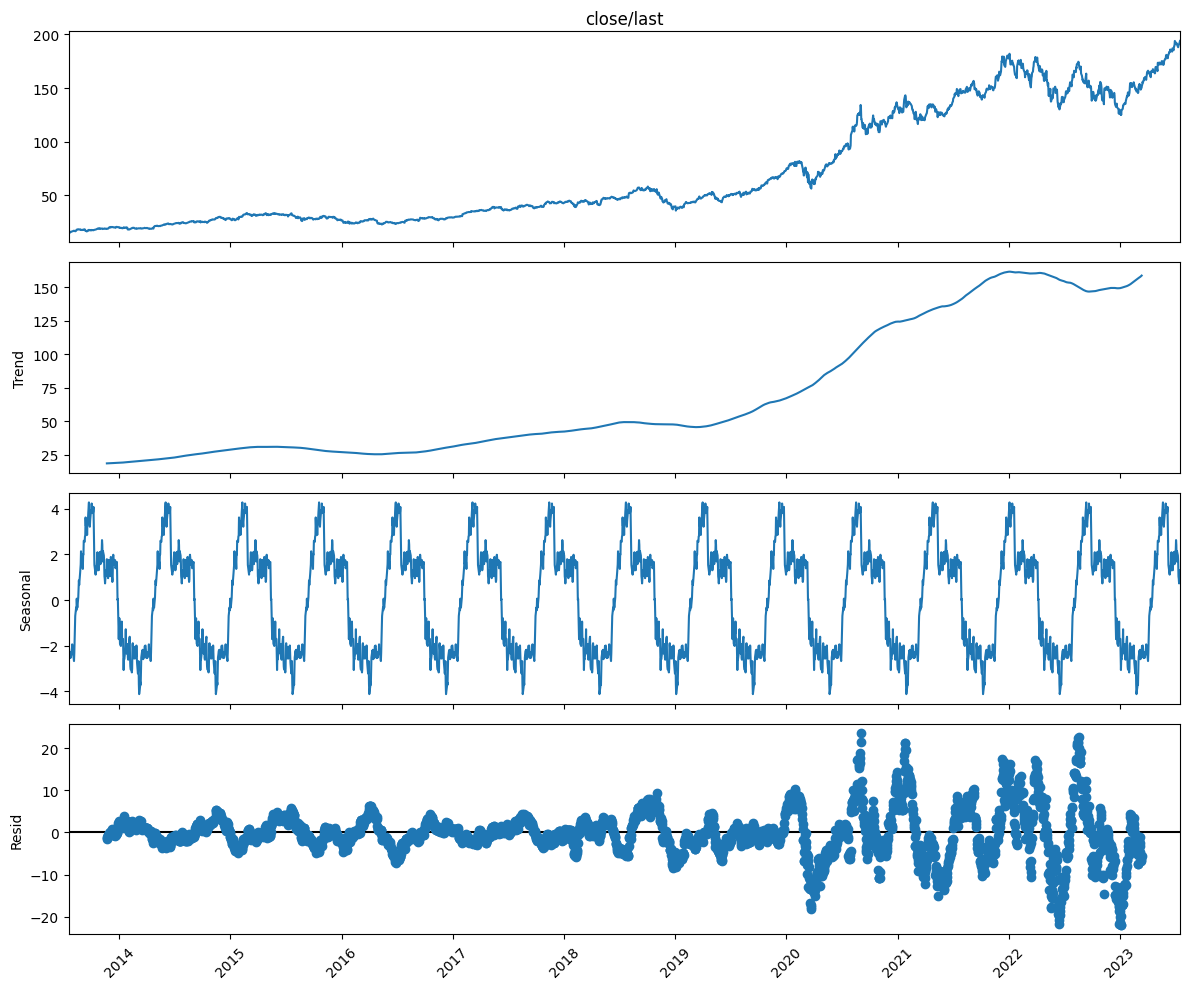

In [204]:
# Assicurati che l'indice sia di tipo datetime e ordinato
if not isinstance(df_apple.index, pd.DatetimeIndex):
    df_apple.index = pd.to_datetime(df_apple.index)

df_apple = df_apple.sort_index()

# Verifica che non ci siano valori mancanti nella colonna 'close/last'
if df_apple['close/last'].isnull().any():
    print("Ci sono valori mancanti nella colonna 'close/last'. Verranno rimossi.")
    df_apple = df_apple.dropna(subset=['close/last'])

# Determina automaticamente la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Imposta il periodo in base alla frequenza
if freq == 'D':  # Dati giornalieri
    period = 252  # Stagionalità annuale (252 giorni di trading)
elif freq == 'W':  # Dati settimanali
    period = 52  # Stagionalità annuale (52 settimane)
elif freq == 'M':  # Dati mensili
    period = 12  # Stagionalità annuale (12 mesi)
else:
    print("Frequenza non riconosciuta. Utilizzo il periodo predefinito per dati giornalieri.")
    period = 252

# Decomposizione additiva
try:
    decomposition = seasonal_decompose(df_apple['close/last'], model='additive', period=period)

    # Plot della decomposizione
    fig = decomposition.plot()

    # Imposta la dimensione del grafico
    fig.set_size_inches(12, 10)

    # Intervallo personalizzato per i tick dell'asse x
    xticks_interval = 252  # Intervallo di un anno per dati giornalieri
    xticks = pd.date_range(start=df_apple.index.min(), end=df_apple.index.max(), freq='YS')
    
    for ax in fig.axes:
        ax.set_xticks(xticks)
        ax.set_xticklabels([tick.strftime('%Y') for tick in xticks], rotation=45)

    # Ottimizza lo spazio tra i sottografi
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"Errore durante la decomposizione: {e}")
    print("Verifica che la serie temporale abbia una lunghezza sufficiente rispetto al periodo.")

In [205]:
# Test Dickey-Fuller
result = adfuller(df_apple['close/last'])

# Stampa i risultati
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: 0.6861245831836653
p-value: 0.9895568550388314
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}


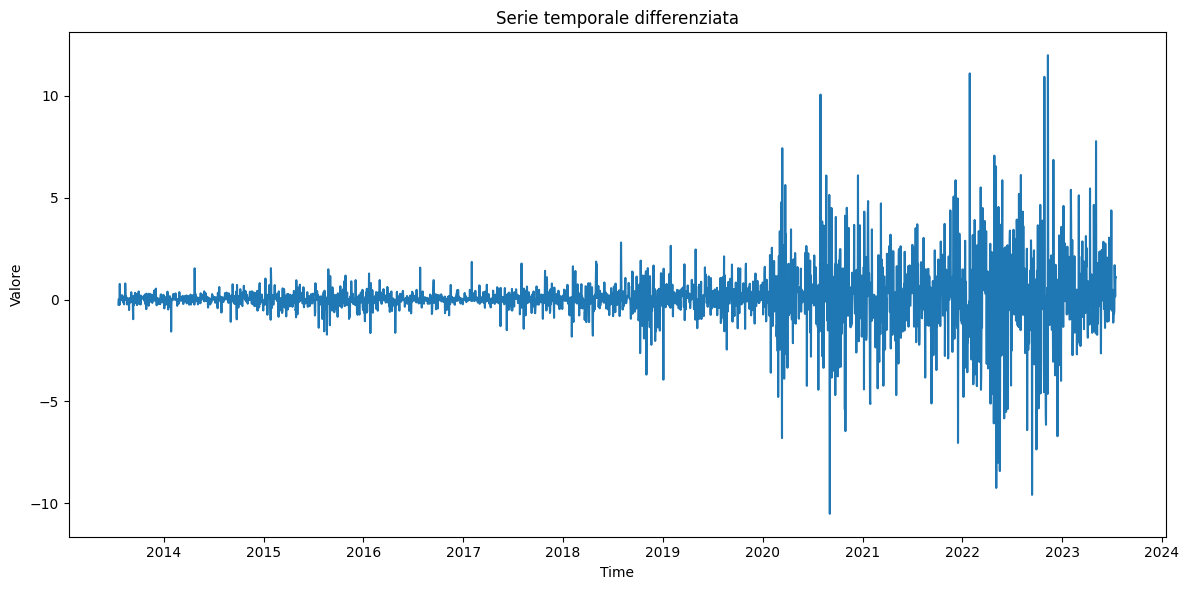

In [206]:
# Differenziazione della serie temporale
differenced_data = df_apple['close/last'].diff().dropna()

# Generazione della figura
plt.figure(figsize=(12, 6))
plt.plot(differenced_data)
plt.title('Serie temporale differenziata')
plt.xlabel('Time')
plt.ylabel('Valore')
plt.tight_layout()
# plt.savefig('differenced_series.png')

In [207]:
# Differenziazione della serie temporale
df_apple['diff_close/last'] = df_apple['close/last'].diff().dropna()
# Verifica della stazionarieta' della serie differenziata
result_diff = adfuller(df_apple['diff_close/last'].dropna())
print(f"ADF Statistic (differenziata): {result_diff[0]}")
print(f"p-value (differenziata): {result_diff[1]}")
print(f"Critical Values (differenziata): {result_diff[4]}")

ADF Statistic (differenziata): -12.754663960431214
p-value (differenziata): 8.389622355085284e-24
Critical Values (differenziata): {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}


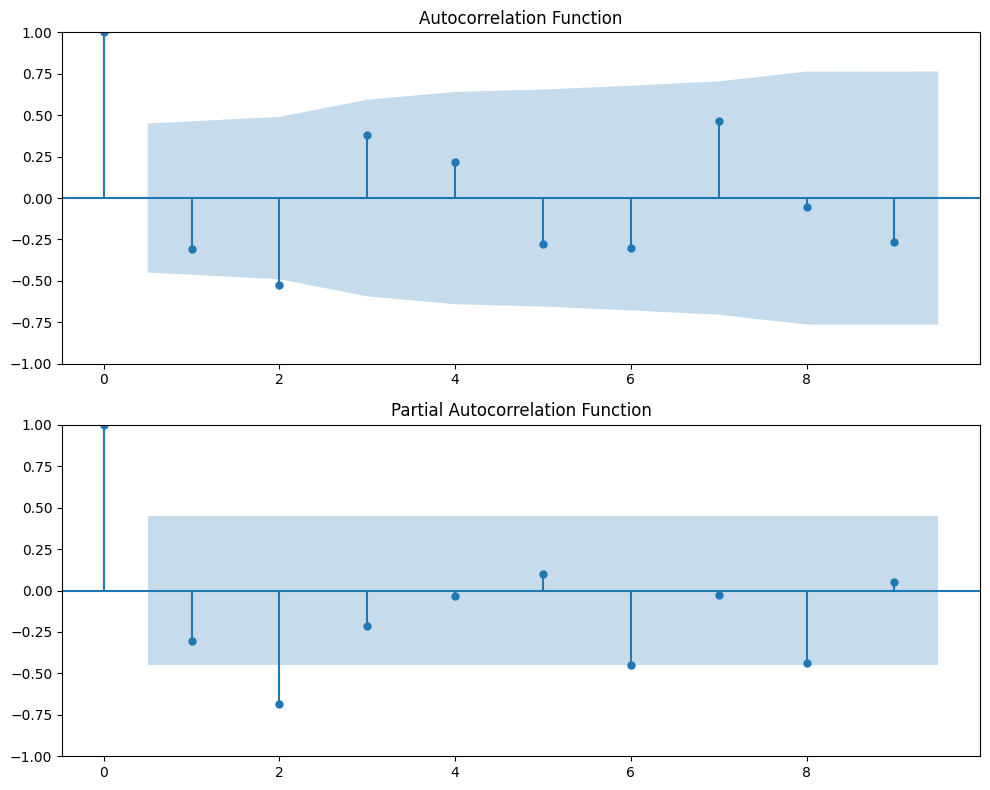

In [208]:
# Create a larger example dataset
df_apple = pd.DataFrame({
    'close/last': [150, 152, 153, 155, 157, 159, 160, 158, 162, 164, 
                   163, 165, 168, 170, 169, 172, 174, 173, 175, 177]
})

# Calculate differences
differenced_data = df_apple['close/last'].diff().dropna()

# Calculate maximum allowed lags (50% of sample size)
max_lags = len(differenced_data) // 2

# Create plots with appropriate number of lags
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(differenced_data, lags=max_lags, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(differenced_data, lags=max_lags, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [209]:
print(df_cleaned['date'].head(10))  # Visualizza i primi 10 valori

# Verifica e correggi il formato della colonna 'date'
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%d/%m/%Y', errors='coerce')

df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'close/last']]
df_apple['date'] = pd.to_datetime(df_apple['date'], dayfirst=True)  # Usa il formato corretto
df_apple = df_apple.set_index('date')  # Imposta 'date' come indice
df_apple = df_apple.sort_index()  # Ordina l'indice

split_date = '2022-12-31'

# Conferma la presenza di entrambe le colonne
print(df_apple.head())

# Dividere il dataset in training e test
split_date = '2022-12-31'
train_data = df_apple[:split_date][['close/last', 'volume']]
test_data = df_apple[split_date:][['close/last', 'volume']]

# Verifica la suddivisione
print(f"Numero di osservazioni nel training set: {len(train_data)}")
print(f"Numero di osservazioni nel test set: {len(test_data)}")



0   2023-07-17
1   2023-07-14
2   2023-07-13
3   2023-07-12
4   2023-07-11
5   2023-07-10
6   2023-07-07
7   2023-07-06
8   2023-07-05
9   2023-07-03
Name: date, dtype: datetime64[ns]
            close/last
date                  
2013-07-18     15.4199
2013-07-19     15.1768
2013-07-22     15.2254
2013-07-23     14.9639
2013-07-24     15.7325


KeyError: "['volume'] not in index"

In [ ]:
# Assicurati che 'volume' sia incluso in train_data
train_data = df_apple[:split_date][['close/last', 'volume']]
test_data = df_apple[split_date:][['close/last', 'volume']]

# Controlli preliminari
print(f"Numero di osservazioni nel training set: {len(train_data)}")
print(f"Numero di osservazioni nel test set: {len(test_data)}")
print(f"Valori mancanti in train_data:\n{train_data.isnull().sum()}")
print(f"Valori mancanti in test_data:\n{test_data.isnull().sum()}")

# Modello ARIMA
arima_model = ARIMA(train_data['close/last'], order=(2, 1, 2))
arima_fit = arima_model.fit()

# Modello SARIMAX
sarimax_model = SARIMAX(
    train_data['close/last'], 
    exog=train_data['volume'], 
    order=(2, 1, 2), 
    seasonal_order=(1, 1, 1, 252)
)
sarimax_fit = sarimax_model.fit()

# Stampa dei sommari dei modelli
print("Sommario ARIMA:")
print(arima_fit.summary())

print("\nSommario SARIMAX:")
print(sarimax_fit.summary())


KeyError: "['volume'] not in index"